# B. State purification with qubit-mediated measurement

In [1]:
# ruff: noqa
import os

os.sys.path.append("..")
from feedback_grape.fgrape import optimize_pulse_with_feedback
import jax.numpy as jnp

## The cavity is initially in a  mixed state --> Goal is to purify the state

We are trying to maximize the property determined by $tr (\rho_{\text{cav}}^2)$ which is the purity

In the following, we consider an adaptive measurement
scheme, demonstrated in a series of experiments on Rydberg atoms interacting
with microwave cavities. In this scheme, the
cavity is coupled to an ancilla qubit, which can then be
read out to update our knowledge of the quantum state of
the cavity.

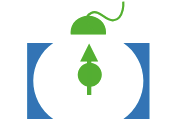

In [2]:
# initial state is a thermal state
n_average = 5
N_cavity = 30
# natural logarithm
beta = jnp.log((1 / n_average) + 1)
diags = jnp.exp(-beta * jnp.arange(N_cavity))
normalized_diags = diags / jnp.sum(diags, axis=0)
rho_cav = jnp.diag(normalized_diags)

### Now the thing is here, we don't need a rho_final because the purity or the reward that we want to maximize is $tr (\rho_{\text{cav}}^2)$.
Unlike fidelity expressions which wants to find how close to states are

## Next Step is to construct our POVM

In [3]:
from feedback_grape.utils.operators import cosm, sinm

In [4]:
from feedback_grape.utils.operators import create, destroy
import jax


def povm_measure_operator(measurement_outcome, gamma, delta):
    """
    POVM for the measurement of the cavity state.
    returns Mm ( NOT the POVM element Em = Mm_dag @ Mm ), given measurement_outcome m, gamma and delta
    """
    # TODO: see if there is a better way other than flattening
    number_operator = create(N_cavity) @ destroy(N_cavity)
    angle = (gamma * number_operator) + delta / 2
    return jnp.where(
        measurement_outcome == 1,
        cosm(angle),
        sinm(angle),
    )

In [5]:
# TODO: Have a default NN and then give user the ability to supply a model or a function
# With log p terms: 0.0.9984141684258416
# Without log p terms: 0.999796307373522
# Answer: why does RNN outputs two the same, then two the same, then two the same and so on? -> calculate during forward proagation then again during back_propagation
from feedback_grape.fgrape_helpers import RNN
import numpy as np
# Create an array of dicts with random initializations between -2pi and 2pi

initial_params = {
    "POVM": [0.1, -3 * jnp.pi / 2],
}
result = optimize_pulse_with_feedback(
    U_0=rho_cav,
    C_target=rho_cav,
    parameterized_gates=[povm_measure_operator],
    measurement_indices=[0],
    initial_params=initial_params,
    num_time_steps=5,
    mode="nn",
    goal="purity",
    optimizer="adam",
    max_iter=100,
    convergence_threshold=1e-20,
    learning_rate=0.005,
    type="density",
    batch_size=20,
    RNN=RNN,
)

Iteration 0, Loss: 0.204537
Iteration 10, Loss: 0.531617
Iteration 20, Loss: 0.712362
Iteration 30, Loss: 0.616026
Iteration 40, Loss: 0.609484
Iteration 50, Loss: 0.635278
Iteration 60, Loss: 0.713524
Iteration 70, Loss: 0.702947
Iteration 80, Loss: 0.728282
Iteration 90, Loss: 0.660736


In [6]:
result

FgResult(optimized_trainable_parameters={'params': {'Dense_0': {'bias': Array([-0.03742616, -0.04074473], dtype=float32), 'kernel': Array([[-0.3637958 ,  0.13433856],
       [-0.13773654, -0.06174573],
       [ 0.1571799 ,  0.17044963],
       [ 0.14391567, -0.07208496],
       [ 0.16176718,  0.08653028],
       [-0.28790298,  0.20076448],
       [-0.13539754,  0.13540821],
       [ 0.18607464, -0.14799249],
       [-0.34213585, -0.16245575],
       [-0.12275074,  0.07856008],
       [-0.03142395, -0.0276339 ],
       [-0.4532437 , -0.04314669],
       [-0.13825893, -0.07234596],
       [ 0.18181123, -0.14843139],
       [ 0.2865304 ,  0.22702259],
       [ 0.38982004, -0.34831148],
       [ 0.08969459,  0.27740526],
       [ 0.14906126, -0.23212726],
       [-0.06685473, -0.15964882],
       [ 0.28566316,  0.00309713],
       [ 0.17839353, -0.11756971],
       [ 0.03537137,  0.11755065],
       [ 0.137099  ,  0.01723858],
       [ 0.01743751, -0.22974943],
       [-0.00076287, -0.2720

In [7]:
print(result.final_fidelity)

None


In [8]:
print(result.final_state)

[[[ 1.04175794e-03+0.j  5.57223836e-03+0.j  1.83750379e-02+0.j ...
   -1.57047456e-03+0.j -8.31489684e-04+0.j  7.12079399e-05+0.j]
  [ 5.57223836e-03+0.j  2.28579451e-01+0.j -1.96674372e-01+0.j ...
   -1.20338586e-03+0.j  2.39578410e-03+0.j -3.41890790e-04+0.j]
  [ 1.83750379e-02+0.j -1.96674372e-01+0.j  7.61799207e-01+0.j ...
   -3.83865954e-02+0.j -2.48233414e-02+0.j  2.32910165e-03+0.j]
  ...
  [-1.57047456e-03+0.j -1.20338586e-03+0.j -3.83865954e-02+0.j ...
    2.68196717e-03+0.j  1.52935339e-03+0.j -1.39996512e-04+0.j]
  [-8.31489684e-04+0.j  2.39578410e-03+0.j -2.48233414e-02+0.j ...
    1.52935339e-03+0.j  9.51275805e-04+0.j -9.17439292e-05+0.j]
  [ 7.12079399e-05+0.j -3.41890790e-04+0.j  2.32910165e-03+0.j ...
   -1.39996512e-04+0.j -9.17439292e-05+0.j  9.48913006e-06+0.j]]

 [[ 4.09373659e-02+0.j  4.55282395e-02+0.j  6.69270360e-02+0.j ...
   -8.38601987e-04+0.j -2.28628541e-02+0.j -6.80759082e-03+0.j]
  [ 4.55282395e-02+0.j  5.06537319e-02+0.j  7.44441872e-02+0.j ...
   -9.21

In [9]:
# 0.33295458963455277
print(result.final_purity)

0.8951083495574492


In [10]:
from feedback_grape.utils.purity import purity

print("initial purity:", purity(rho=rho_cav))
for i, state in enumerate(result.final_state):
    print(f"Purity of state {i}:", purity(rho=state))

initial purity: 0.09167828042260612
Purity of state 0: 0.7200979502225813
Purity of state 1: 0.9371730362509093
Purity of state 2: 0.515980040464222
Purity of state 3: 0.9424623442889312
Purity of state 4: 0.9960140965714996
Purity of state 5: 0.9657160356612688
Purity of state 6: 0.9791018414803933
Purity of state 7: 0.7227525756904214
Purity of state 8: 0.9539342446026517
Purity of state 9: 0.9702102318775968
Purity of state 10: 0.9650327103306018
Purity of state 11: 0.8691025619915156
Purity of state 12: 0.9539342446026517
Purity of state 13: 0.9996005828872083
Purity of state 14: 0.8792896967074441
Purity of state 15: 0.5996825879840645
Purity of state 16: 0.9988683520649854
Purity of state 17: 0.9909461964053844
Purity of state 18: 0.9439121299041845
Purity of state 19: 0.9983555311604688


In [11]:
result.returned_params

[[Array([[ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898],
         [ 0.1       , -4.71238898]], dtype=float64)],
 [Array([[-0.45261633, -0.05939795],
         [-0.45261633, -0.05939795],
         [-0.45261633, -0.05939795],
         [-0.45261633, -0.05939795],
         [-0.45261633, -0.05939795],
         [-0.45261633, -0.05939795],
         [-0.4526163

In [12]:
print(jax.random.PRNGKey(9))
time_step_keys = jax.random.split(jax.random.PRNGKey(9), 5)
print(time_step_keys)
for key in time_step_keys:
    print(jax.random.uniform(key))

[0 9]
[[2822284597 2722679661]
 [ 143080583 4281670255]
 [2676565412 4109519897]
 [1877436067 1979300842]
 [3339921199 4267639851]]
0.16232149317805766
0.07829857808883056
0.8422083576204116
0.23698051656885277
0.33005660981143814


In [13]:
from feedback_grape.fgrape import povm
import random

time_steps = 5

rho = rho_cav
print("initial purity:", purity(rho=rho))

rand_num = random.randint(1, 50)

time_step_keys = jax.random.split(jax.random.PRNGKey(rand_num), time_steps)
for i in range(time_steps):
    params = result.returned_params[i][0]
    print(f"params for time step {i}:", params[0])
    rho, _, _ = povm(rho, povm_measure_operator, params[0], time_step_keys[i])
    print(f"purity of rho after time step {i}", purity(rho=rho))
final_rho_cav = rho

initial purity: 0.09167828042260612
params for time step 0: [ 0.1        -4.71238898]
purity of rho after time step 0 0.13627289474831314
params for time step 1: [-0.45261633 -0.05939795]
purity of rho after time step 1 0.23026054123737147
params for time step 2: [-0.98939011  0.01939561]
purity of rho after time step 2 0.26737597503001603
params for time step 3: [-0.64306773  0.05514154]
purity of rho after time step 3 0.41688867785976863
params for time step 4: [ 0.18586827 -0.125871  ]
purity of rho after time step 4 0.5997462836016951


In [14]:
from feedback_grape.utils.povm import (
    _probability_of_a_measurement_outcome_given_a_certain_state,
)

variables = jnp.array([0.1, -3 * jnp.pi / 2])
# variables_2 = {
#     "gamma": 0.1,
#     "delta": -3 * jnp.pi / 2,
# }
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, -1, povm_measure_operator, variables
    )
)
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, 1, povm_measure_operator, variables
    )
)

0.25827164104671196
0.7417283589532875


### Check stash for replacement of dict implementation

In [15]:
print("Final state after application of amplitudes:", final_rho_cav)

Final state after application of amplitudes: [[ 2.35548245e-03+0.j -3.57515411e-02+0.j  5.97308255e-04+0.j
  -2.09312330e-04+0.j -8.04076754e-04+0.j -6.25478904e-03+0.j
  -1.14137400e-03+0.j -9.68376309e-04+0.j -9.85661603e-04+0.j
  -1.28250517e-03+0.j -1.34386913e-03+0.j -1.38082982e-03+0.j
  -1.66573673e-03+0.j -1.71049955e-03+0.j -1.43574038e-03+0.j
  -1.50688419e-03+0.j -1.90682765e-03+0.j -1.92160606e-03+0.j
  -1.68629269e-03+0.j -1.81644467e-03+0.j -2.43424403e-03+0.j
  -2.15278384e-03+0.j -1.57315136e-03+0.j -1.54961989e-03+0.j
  -1.33537072e-03+0.j -1.18606866e-03+0.j -1.02858327e-03+0.j
  -9.83885160e-04+0.j -1.13312081e-03+0.j -3.29274347e-04+0.j]
 [-3.57515411e-02+0.j  7.41283120e-01+0.j -1.22580992e-02+0.j
   6.00115005e-03+0.j -1.02059198e-03+0.j  3.30167412e-03+0.j
   8.85625277e-03+0.j  9.50179092e-03+0.j  1.32794171e-02+0.j
   1.70892332e-02+0.j  1.98876577e-02+0.j  1.94377971e-02+0.j
   2.43892732e-02+0.j  2.43516003e-02+0.j  1.63896736e-02+0.j
   2.01548250e-02+0.j  2

In [16]:
print("Final state from solver:", result.final_state)

Final state from solver: [[[ 1.04175794e-03+0.j  5.57223836e-03+0.j  1.83750379e-02+0.j ...
   -1.57047456e-03+0.j -8.31489684e-04+0.j  7.12079399e-05+0.j]
  [ 5.57223836e-03+0.j  2.28579451e-01+0.j -1.96674372e-01+0.j ...
   -1.20338586e-03+0.j  2.39578410e-03+0.j -3.41890790e-04+0.j]
  [ 1.83750379e-02+0.j -1.96674372e-01+0.j  7.61799207e-01+0.j ...
   -3.83865954e-02+0.j -2.48233414e-02+0.j  2.32910165e-03+0.j]
  ...
  [-1.57047456e-03+0.j -1.20338586e-03+0.j -3.83865954e-02+0.j ...
    2.68196717e-03+0.j  1.52935339e-03+0.j -1.39996512e-04+0.j]
  [-8.31489684e-04+0.j  2.39578410e-03+0.j -2.48233414e-02+0.j ...
    1.52935339e-03+0.j  9.51275805e-04+0.j -9.17439292e-05+0.j]
  [ 7.12079399e-05+0.j -3.41890790e-04+0.j  2.32910165e-03+0.j ...
   -1.39996512e-04+0.j -9.17439292e-05+0.j  9.48913006e-06+0.j]]

 [[ 4.09373659e-02+0.j  4.55282395e-02+0.j  6.69270360e-02+0.j ...
   -8.38601987e-04+0.j -2.28628541e-02+0.j -6.80759082e-03+0.j]
  [ 4.55282395e-02+0.j  5.06537319e-02+0.j  7.4444

In [17]:
# # Define initial state (a thermal state for example)
# import os

# os.sys.path.append("..")
# from feedback_grape.fgrape import optimize_pulse_with_feedback
# from feedback_grape.utils.operators import create, destroy, cosm, sinm
# import jax.numpy as jnp

# n_average = 2
# N_cavity = 30
# beta = jnp.log((1 / n_average) + 1)
# diags = jnp.exp(-beta * jnp.arange(N_cavity))
# normalized_diags = diags / jnp.sum(diags, axis=0)
# rho_cav = jnp.diag(normalized_diags)


# def povm_measure_operator(measurement_outcome, gamma, delta):
#     """
#     POVM for the measurement of the cavity state.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return jnp.where(
#         measurement_outcome == 1,
#         cosm(angle),
#         sinm(angle),
#     )


# def unitary_gate(gamma, delta):
#     """
#     Example unitary gate operation.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return cosm(angle)


# # Initial parameters for both gates NOTE those are really important
# initial_params = {
#     "POVM": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
#     "U_qc": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
# }

# # Run the optimization
# result = optimize_pulse_with_feedback(
#     U_0=rho_cav,
#     C_target=None,
#     parameterized_gates=[povm_measure_operator, unitary_gate],
#     measurement_indices=[0],  # Only the first gate is a measurement
#     initial_params=initial_params,
#     num_time_steps=5,
#     mode="nn",
#     goal="purity",
#     optimizer="adam",
#     max_iter=1000,
#     convergence_threshold=1e-6,
#     learning_rate=0.1,
#     type="density",
# )

# print(f"Final purity: {result.final_purity}")

In [18]:
import jax.numpy as jnp
import jax

initial_params = {
    "POVM": [0.1, 0.2],
    "test": [0.3, 0.4],
    "test2": 0.5,
    "test3": [0.1],
}


# refer to the old ways in older commits to keep the order while using nested dicts - does not use tree utils though
def flatten_dict(d):
    res = []
    shapes = []
    for value in d.values():
        flat_params = jax.tree_util.tree_leaves(value)
        res.append(flat_params)
        shapes.append(len(flat_params))
    return res, shapes


flat_params, shapes = flatten_dict(initial_params)
print(flat_params)
print(shapes)

[[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]
[2, 2, 1, 1]


In [19]:
print("restored_params", flat_params)

restored_params [[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]


In [20]:
jnp.array([0.1, 0.2, 0.2])

Array([0.1, 0.2, 0.2], dtype=float64)

In [21]:
batch_size = 2

In [22]:
rho_final_batched = jnp.repeat(jnp.expand_dims(rho_cav, 0), batch_size, axis=0)

In [23]:
rho_final_batched.shape

(2, 30, 30)

In [24]:
parent_key = jax.random.PRNGKey(0)
print(parent_key.shape)
rng_keys = jax.random.split(parent_key)

(2,)


In [25]:
rng_keys[0].shape

(2,)

In [26]:
print(jnp.array([1, 3]) * -jnp.array([2, 2]))

[-2 -6]
